# Import Packages

In [1]:
from collections import Counter

from matplotlib.cm import get_cmap
import pandas as pd
import plotly.express as px

from pymodulon.core import IcaData
from pymodulon.plotting import *
from pymodulon.io import load_json_model, save_to_json

In [2]:
pd.set_option('display.max_rows', 300)

# Load IcaData object

In [3]:
ica_data = load_json_model('../data/precise2/precise2.json.gz')

In [4]:
imod_table = ica_data.imodulon_table

# Category Breakdowns

In [5]:
def bar_and_pie(category, figsize=(12, 4)):
    imod_cat_counts = Counter(imod_table[category])
    sorted_cats, sorted_counts = zip(*sorted(list(imod_cat_counts.items()), key=lambda tup: tup[1], reverse=True))
    
    if len(sorted_cats) < 10:
        color_dict = dict(zip(sorted_cats, get_cmap('tab10').colors))
    elif len(sorted_cats) < 20:
        color_dict = dict(zip(sorted_cats, get_cmap('tab20').colors))
    elif len(sorted_cats) < 40:
        color_dict = dict(zip(sorted_cats, get_cmap('tab20b').colors + get_cmap('tab20c').colors))
    # add a manual line for the unexplained variance category
    color_dict['Unexplained'] = 'gray'
    
    fig, (ax_bar, ax_pie_var) = plt.subplots(1, 2, figsize=figsize)

    bar_range = -1 * np.arange(0, len(sorted_cats))
    ax_bar.barh(bar_range, sorted_counts, tick_label=sorted_cats, color=[color_dict[cat] for cat in sorted_cats])
    ax_bar.set_xlabel('# of iModulons', fontsize=16)
    ax_bar.tick_params(axis='both', labelsize=15)
    if len(sorted_counts) < 20:
        for height, count in zip(bar_range, sorted_counts):
            ax_bar.text(count+1, height, count, fontsize=15, va='center')
        ax_bar.set_xlim(right=sorted_counts[0] + 15)
    for i in ax_bar.spines.values():
        i.set_linewidth(1.5)
    
    exp_vars = []
    exp_var_tot = imod_table['exp_var'].sum()
    # manually add in the "unexplained" category
    for cat in sorted_cats:
        exp_var = imod_table[imod_table[category] == cat]['exp_var'].sum()
        exp_vars.append(exp_var)
    sorted_vars, sorted_cats_var = zip(*sorted(zip(exp_vars, sorted_cats), key=lambda tup: tup[0], reverse=True))

    # make unexplained last
    unexp_var = 100 - imod_table['exp_var'].sum()
    sorted_vars = list(sorted_vars)
    sorted_vars.append(unexp_var)
    sorted_cats_var = list(sorted_cats_var)
    sorted_cats_var.append('Unexplained')

    
    pie_labels_var = []
    for cat, var in zip(sorted_cats_var, sorted_vars):
        if var < 4.5 and len(sorted_cats_var) > 4:
            pie_labels_var.append('')
        else:
            pie_labels_var.append(f'{cat} ({max(int(np.round(var, decimals=0)), 1)}%)')
    
    ax_pie_var.pie(sorted_vars, labels=pie_labels_var, colors=[color_dict[cat] for cat in sorted_cats_var],
              textprops={'fontsize': 14})
    ax_pie_var.set_title('Explained Variance', fontsize=16)
    
    plt.tight_layout()
    
    return fig

## iModulon Category

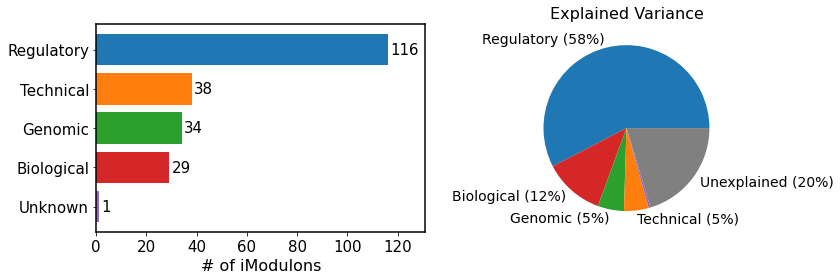

In [6]:
fig_enrich = bar_and_pie('enrichment_category')
plt.savefig('fig3/enrich_categories.pdf')

## System Category

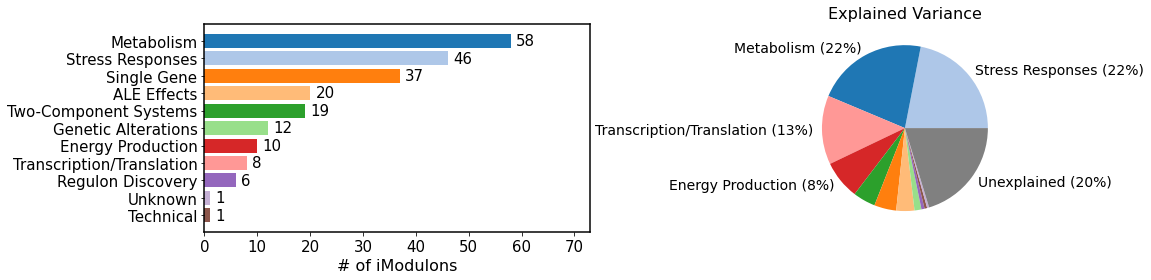

In [8]:
fig_system = bar_and_pie('system_category', figsize=(16, 4))
plt.savefig('fig3/system_categories.pdf')

# Overall Variance

<ipython-input-25-e02ccfa231c5>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(list(sorted_imod_table.index)[:n_top])), rotation=0, fontsize=10, ha='right')


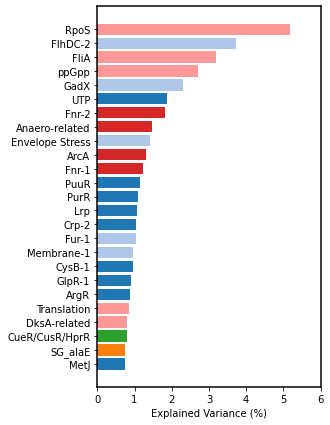

In [25]:
sorted_imod_table = imod_table.sort_values(by='exp_var', ascending=False)
imod_cat_counts = Counter(imod_table['system_category'])
sorted_cats, sorted_counts = zip(*sorted(list(imod_cat_counts.items()), key=lambda tup: tup[1], reverse=True))
color_dict = dict(zip(sorted_cats, get_cmap('tab20').colors))

_, ax = plt.subplots(figsize=(4, 7))
n_top = 25
for i, im_row in enumerate(sorted_imod_table.itertuples()):

    if i < n_top:
        ax.barh(0-i, im_row.exp_var, color=color_dict[im_row.system_category])
        
ax.set_xlabel('Explained Variance (%)')
ax.set_yticklabels(list(reversed(list(sorted_imod_table.index)[:n_top])), rotation=0, fontsize=10, ha='right')
ax.set_yticks(range(-n_top+1, 1))
ax.set_xticks(range(7))
for i in ax.spines.values():
    i.set_linewidth(1.5)
plt.savefig('fig3/imod_variance.pdf', bbox_inches='tight')